# Proper orthogonal decomposition as an analysis and compression tool

In this notebook, we investigate the POD's implementation using SVD, and a simple application of mode analysis and compression of a image time-series (video).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Load time-series data

We will consider a toy example where we apply POD to an image time-series (i.e. video).

In [2]:
from IPython.display import Video

video_path = './data/km3.mov'
Video(video_path)

To actually handle the video data, we will use the `cv2` package. 

You can install it via
```shell
pip install opencv-python
```

In [3]:
import cv2

video = cv2.VideoCapture(video_path)

# Convert the video to a numpy array of frames (grayscale) and normalize to [0, 1]
frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary_frame = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)
    binary_frame = 1 - binary_frame / 255.0  # Normalize to [0, 1], and reverse to make sparse
    frames.append(binary_frame)

video_array = np.array(frames)
video.release()

The shape of `video_array` will be [num_frames, height, width].

In [4]:
num_frames, height, width = video_array.shape
video_array.shape

(581, 460, 358)

Now, we convert the video data into an array for POD.

This array will be of size $m \times n$
- $m = $ num_frames is the temporal dimension
- $n = $ height $\times$ width is the spatial dimension



In [5]:
u = video_array.reshape(num_frames, -1)

## Proper orthogonal decomposition (or equivalently, SVD)

Implementing the POD of the spatio-temporal data can be achieved simply from calling an SVD routine.

Note that the size of u is quite large...

In [6]:
u.shape

(581, 164680)

However, it is quite sparse!

(array([92068748.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,  3610332.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

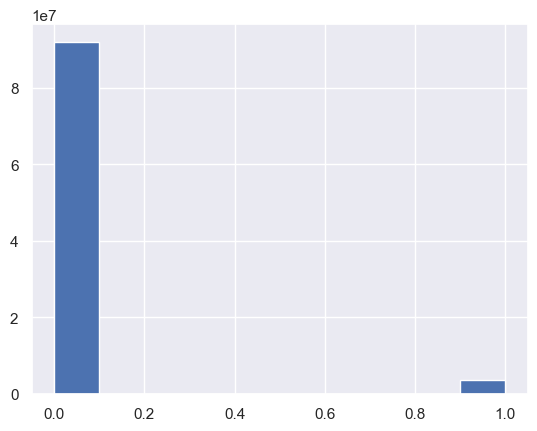

In [7]:
plt.hist(u.ravel())

Thus, we will use the sparse version of SVD, `scipy.sparse.linalg.svds` that is especially suited for such problems.

In [8]:
from scipy.sparse.linalg import svds

num_components = 32

# Compute the singular value decomposition
v, s, w = svds(u, k=num_components, which='LM')

By default, `svds` does not return singular values in descending order, so we will sort them first and transform the singular vectors accordingly.

In [9]:
sorted_indices = np.argsort(-s)
s = s[sorted_indices]
v = v[:, sorted_indices]
w = w[sorted_indices]

Let us now look at the singular value decay...

In [14]:
s.shape

(32,)

In [15]:
s

array([591.84478182, 290.24072811, 280.40246416, 262.76286899,
       247.76323314, 235.14483671, 231.59756367, 230.75990999,
       227.76402857, 219.59901186, 213.80898892, 213.16194686,
       212.54440368, 209.48911562, 207.58075492, 204.83946803,
       202.44223443, 200.53790854, 199.53535908, 197.17012342,
       196.91065399, 194.30011183, 193.41669781, 191.91129305,
       190.96868586, 190.23789418, 189.1512846 , 188.82757434,
       185.89340368, 184.27237882, 183.48107087, 182.43518137])

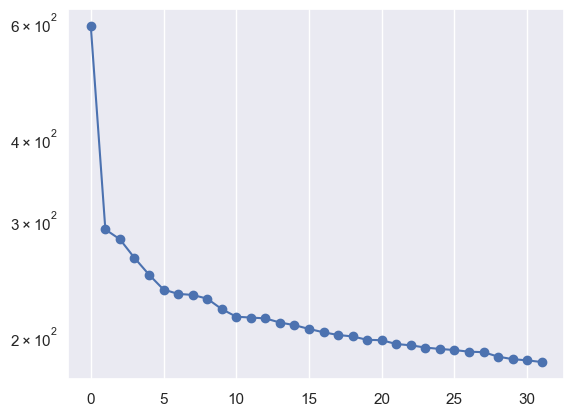

In [17]:
plt.semilogy(s, 'o-')

We see that the singular values are decaying, but there is no clear cut-off before 32 modes (other than the first mode), so we will take them all.

In [11]:
r = 32
u_compressed = v[:, :r] @ np.diag(s[:r]) @ w[:r, :]

Let us look at the first 6 spatial singular vectors (which are the spatial POD modes). What do they mean?

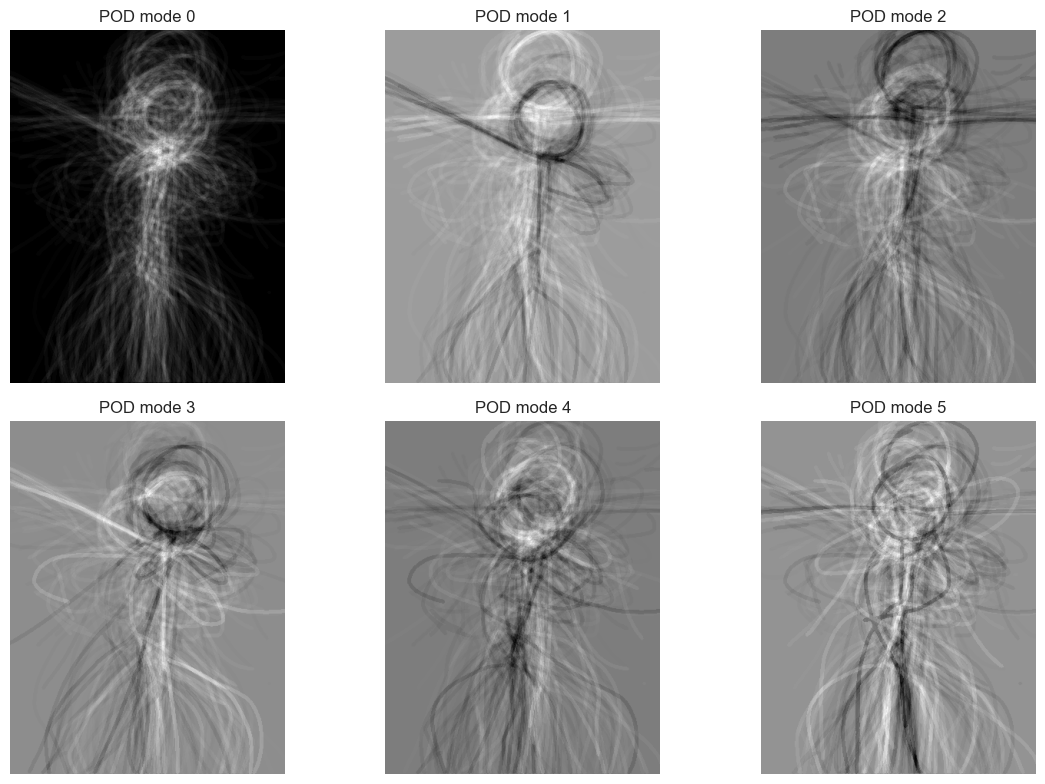

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(w[i].reshape(height, width), cmap='gray')
    ax.set_title(f'POD mode {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


Now, we can use the POD to compress the source time-series (video) as follows.

Originally, the video is of size
$$
    u \in \R^{m\times n}
$$
where $m$ is the number of time steps and $n$ is the number of pixels. Its size is $m\times n$.

By writing
$$
    u \approx v s w^T
$$
where $v \in \R^{m\times r}, s\in\R^{r}$ and $w \in \R^{n\times r}$.
The total size of this decomposition is
$$
    mr + r + nr = r(m+n+1) \ll mn.
$$


Let us look at the compressed data.

In [18]:
video_compressed = u_compressed.reshape(num_frames, height, width)
video_compressed = (video_compressed > 0.25).astype(int)  # binarise to remove some noise

In [19]:
output_path = './data/video_compressed.mp4'

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30, (width, height), isColor=False)
for frame in video_compressed:
    frame = (frame * 255).astype(np.uint8)
    out.write(frame)
out.release()

In [22]:
!open {output_path}

How much compression did we achieve?

In [21]:
original_size = u.shape[0] * u.shape[1]
compressed_size = v.shape[0] * v.shape[1] + s.shape[0] + w.shape[0] * w.shape[1]

print(f"Compression ratio: {compressed_size / original_size}")

Compression ratio: 0.05527210336888691


not too bad!

## Summary

We saw here that POD (really SVD on the spatio-temporal data) can be used to 
- analyse key spatial modes
- give a reduced representation of the dynamics

Exercise:
- try to improve the performance!
- How should you measure performance?
- Can you say anything about the temporal modes $v_k$?